# Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# color-blind color scheme
plt.style.use('tableau-colorblind10')

Let's make sure that we are using numpy 1.26.4 for backwards compatibility (last version before 2.0, which doesn't yet have support from all packages):

In [2]:
np.version.version

'1.26.4'

# A simple LIF neuron

We'll define a simple leaky-integrate-and-fire neuron model with leaky integration of a current $I$.

This implementation is loosely based on:
https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/LIF_ei_balance_irregularity.ipynb#scrollTo=Hhk7e-QreVSh







## LIF dynamcis

One neuron follows the LIF dynamcis

$C_m \frac{dv}{dt} = - g_l [v(t) - V_l] + I$,

where $v(t)$ is the membrane voltage, $C_m$ is the membrane capactitance, $g_l$ the leak conductance, $V_l$ the leak potential.


Dividing by $g_l$, we rewrite this more simply as

$\tau_m \frac{dv}{dt} = - [v(t) - V_l] + I/g_l $, where $\tau_m \equiv C_m/g_l $.

Because we can only simulate discrete time steps, we estimate the derivative of $v(t)$ by the Euler forward method:

$\frac{dv}{dt} \mapsto $ `dv / dt` : now, instead of representing the derivative, we have two variables `dv` and `dt`, representing discrete voltage and time differences.

__Note that the Euler method carries hidden assumptions, which can break down and distort results.__

But for now, we should be fine. The discrete time dynamics we will implement are thus:

`dv = {- [v - V_l] + I/g_l } / \tau_m * dt`


### Spiking mechanism



The spiking mechanism is simply implemented by the condition

if $v(t) \geq V_{th}$, then $v(t + dt) = V_{reset}$.

We also implement a refractory period, by adding a counter variable since the last spike. For every time step:

- if neuron currently spiking: `refractory_counter` = `tau_ref/dt` (which expresses $\tau_{ref}$ in terms of time steps)
- if neuron is refractory: clamp voltage to `V_{reset}` and decrease `refractory_counter` by one


## Code

The whole looks like this:

In [3]:
class LIF_neuron:
    # initialize a neuron class
    # provided parameter dictionary params
    def __init__(self, params):
        # attach parameters to object
        self.V_th, self.V_reset = params['V_th'], params['V_reset']   
        self.tau_m, self.g_L = params['tau_m'], params['g_L']        
        self.V_init, self.V_L = params['V_init'], params['V_L']       
        self.dt = params['dt']
        self.tau_ref = params['tau_ref']

        # initialize voltage and current
        self.v = 0.0
        # time steps since last spike
        self.refractory_counter = 0
    
    def LIF_step(self, I):
        """
            Perform one step of the LIF dynamics
        """
        
        currently_spiking = False
        
        if self.refractory_counter > 0:
            # if the neuron is still refractory
            self.v = self.V_reset
            self.refractory_counter = self.refractory_counter - 1
        elif self.v >= self.V_th:
            # if v is above threshold,
            # reset voltage and record spike event
            currently_spiking = True
            self.v = self.V_reset
            self.refractory_counter = self.tau_ref/self.dt
        else:
            # else, integrate the current:
            # calculate the increment of the membrane potential
            dv = self.voltage_dynamics(I)
            # update the membrane potential
            self.v = self.v + dv

        return self.v, currently_spiking
    
    def voltage_dynamics(self, I):
        """
            Calulcates one step of the LI dynamics
        """
        dv = (-(self.v-self.V_L) + I/self.g_L) * (self.dt/self.tau_m)
        return dv
        

You can see that we have split up the functions implementing the dynamics into `LIF_step` and `voltage_dynamics`. We could have put both into the same function, but this will be useful later.

In [4]:
params = {}
### typical neuron parameters###
params['V_th']    = -55. # spike threshold [mV]
params['V_reset'] = -75. #reset potential [mV]
params['tau_m']   = 10. # membrane time constant [ms]
params['g_L']     = 10. #leak conductance [nS]
params['V_init']  = -65. # initial potential [mV]
params['V_L']     = -75. #leak reversal potential [mV]
params['tau_ref']    = 2. # refractory time (ms)
params['dt'] = .1  # Simulation time step [ms]

In [5]:
# initialize one neuron, i.e. an instance of the class
neuron1 = LIF_neuron(params)

In [6]:
# let's check if everything works by performing one step:
neuron1.LIF_step(I=300.0)

(-75.0, True)

In [7]:
# simulate 500 time steps
voltages = []
spikes = []
for _ in range(500):
    v, s = neuron1.LIF_step(I=300.0)
    voltages.append(v)
    spikes.append(s)

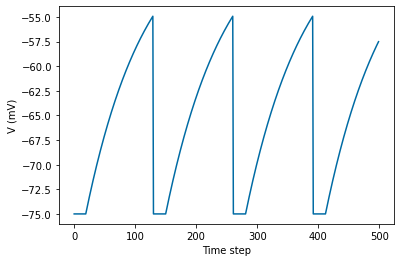

In [8]:
plt.figure()
plt.plot(voltages)
# for s in np.where(spikes)[0]:
#     plt.axvline(s, c='red')
plt.xlabel('Time step')
plt.ylabel('V (mV)');
plt.show()

Neat, so we have a single LIF neuron that spikes regularly.

# Overriding classes with __super__

Let's say that now we want to implement a different class of neurons: [exponential LIF](https://en.wikipedia.org/wiki/Exponential_integrate-and-fire), which have modified dynamics:

$C_m \frac{dv}{dt} = - g_l [v(t) - V_l - \Delta_T \exp\Big( \frac{v(t) - V_{trig}}{\Delta_T} \Big)] + I$.

Instead of firing once $V_{tr}$ is reached, the new term $\Delta_T \exp\Big( \frac{v(t) - V_{trig}}{\Delta_T}\Big)$ starts growing quickly as $v(t)$ approaches $V_{trig}$, modeling a more realistic firing behaviour.

So now, we can set $V_{trig}$ to -55 mV, and the old threshold $V_{th}$ has the new function of acting as a separate reset, which we will set to 0 mV.


## Code

To implement this, we could now copy and modify the `LIF_neuron` class. But as models build on eachother, there is a more efficient way of doing this:

We can initialize the class `ExpLIF_neuron` as a child of `LIF_neuron`, inheriting all of its attributes and functions. The initialization can be inherited by using the `super()` function:

In [9]:
# define new class as child of old class
class ExpLIF_neuron(LIF_neuron):
    def __init__(self, params):
        # build on LIF neuron with same settings
        # (this will run __init__ of the parent class)
        super().__init__(params)
        
        # we only need to attach additional variables:
        self.DeltaT = params['DeltaT']
        self.V_exp_trigger = params['V_exp_trigger']
    
    # now we can just    
    def voltage_dynamics(self, I):
        """
            Calulcates one step of the exp-LI dynamics
        """
        dv = (-(self.v-self.V_L) + I/self.g_L + self.DeltaT * np.exp((self.v-self.V_exp_trigger)/self.DeltaT)) * (self.dt/self.tau_m)
        return dv
        

So that's why we separated `voltage_dynamics` into its own function: because we knew that we will implement a child class that will modify it, but inherit all other properties:

*When you write a class, you want other classes to be able to use it.*
*super() makes it easier for other classes to use the class you're writing.*

*As Bob Martin says, a good architecture allows you to postpone decision making as long as possible.*

*super() can enable that sort of architecture.* [From SO](https://stackoverflow.com/questions/222877/what-does-super-do-in-python-difference-between-super-init-and-expl)

(the problem can be that your base class becomes so generic, it is hard to understand what each function does, but that can be fixed by good documentation)

In [10]:
# additional parameters for ExpLIF neurons
params['DeltaT'] = 10.0  # sharpness of exponential peak
params['V_exp_trigger'] = -55. # threshold for exponential depolarization [mV]
params['V_th'] = 0 # new reset threshold [mV]

In [11]:
# initialize one neuron
neuron2 = ExpLIF_neuron(params)

In [12]:
# simulate 500 time steps
voltages = []
spikes = []
for _ in range(500):
    v, s = neuron2.LIF_step(I=300.0)
    voltages.append(v)
    spikes.append(s)

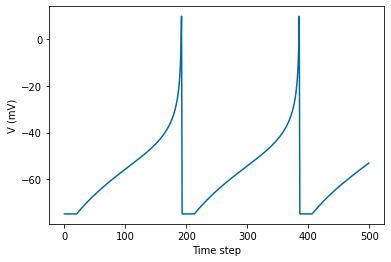

In [13]:
plt.figure()
plt.plot(voltages)
# for s in np.where(spikes)[0]:
#     plt.axvline(s, c='red')
# plt.xlim(0, 100)
plt.xlabel('Time step')
plt.ylabel('V (mV)');
plt.show()

Great! So now we have a modified class which reproduces expLIF dynamics.

# Mutability & a common trap

Let's say we now dare to simulate two neurons. We could just take our class and set up two instances:

In [14]:
# initialize two neuron
neuron3 = ExpLIF_neuron(params)
neuron4 = ExpLIF_neuron(params)

# change parameters a little bit to make it more interesting
neuron4.DeltaT = 7.0
neuron4.V_exp_trigger = -50.0

In [15]:
# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

for neuron in [neuron3, neuron4]:
    I = 0.0
    voltages = []
    spikes = []
    for _ in range(500):
        v, s = neuron.LIF_step(I=I)
        voltages.append(v)
        spikes.append(s)
        I += 10.0
    voltages_arr.append(voltages)
    spikes_arr.append(spikes)



# I = 0.0
# for _ in range(500):
#     voltages = [neuron.LIF_step(I=I)[0] for neuron in [neuron3, neuron4]]
# #         voltages.append(v)
# #         spikes.append(s)
#     voltages_arr.append(voltages)
#     I += 10.0
# #     spikes_arr.append(spikes.copy())

In [16]:
voltages_arr = np.array(voltages_arr)

In [17]:
[neuron.LIF_step(I=300.0) for neuron in [neuron3, neuron4]]

[(-75.0, False), (-75.0, False)]

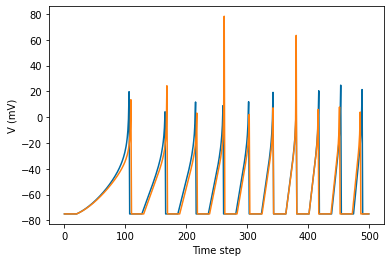

In [18]:
plt.figure()
plt.plot(voltages_arr.T)
plt.xlabel('Time step')
plt.ylabel('V (mV)');
plt.show()

In [19]:
a = 1
b = a
a = 2
b

1

In [20]:
a = [1,2]
b = a
a[0] = 2
b

[2, 2]

In [21]:
arr = []
x = 0
for i in range(10):
    x += np.array([float(i)])
    arr.append(x)
arr

[array([45.]),
 array([45.]),
 array([45.]),
 array([45.]),
 array([45.]),
 array([45.]),
 array([45.]),
 array([45.]),
 array([45.]),
 array([45.])]

In [22]:
arr = []
x = 0
for i in range(10):
    x += np.array([1.0])
    arr.append(x)
arr

[array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.])]

# Extending to populations

In the last section, we quickly hacked how to extend from 1 to 2 neurons. But now, say we want to simulate a population of 100 neurons. We could use the same approach as above:

In [23]:
# population parameters
n_neurons = 100

population1 = [ExpLIF_neuron(params) for _ in range(n_neurons)]

In [24]:
# # we now have a list of 100 neuron objects:
# population1

Let's give them all noisy currents:

In [25]:
mean_I, std_I = 300, 100
n_steps = 10_000

# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

for i, neuron in enumerate(population1):
    voltages = []
    spikes = []
    if i % 10 == 0:
        print(f"Working on neuron {i}")
    for _ in range(n_steps):
        I = np.random.normal(mean_I, std_I)
        v, s = neuron.LIF_step(I=I)
        voltages.append(v)
        spikes.append(s)
    voltages_arr.append(voltages.copy())
    spikes_arr.append(spikes.copy())

Working on neuron 0
Working on neuron 10
Working on neuron 20
Working on neuron 30
Working on neuron 40
Working on neuron 50
Working on neuron 60
Working on neuron 70
Working on neuron 80
Working on neuron 90


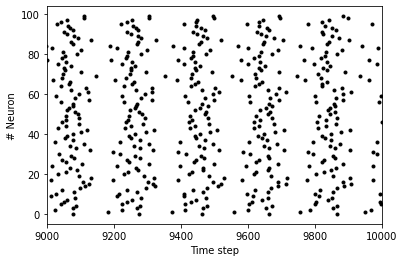

In [30]:
# convert to numpy array
voltages_arr = np.array(voltages_arr)
spikes_arr = np.array(spikes_arr)

# convert spikes to spike_timings
spike_timings = [arr.nonzero()[0] for arr in spikes_arr]

for i in range(n_neurons):
    x = spike_timings[i]
    y = [i for _ in spike_timings[i]]
    plt.scatter(x, y, marker='.', c='black')
plt.xlim(9000,10000)
plt.xlabel('Time step')
plt.ylabel('# Neuron')
plt.show()

So it works, but that scales terribly, because every neuron is simulated sequentially.

How can we parallelize this?

## Resisting the urge to hack it

The essential issue is that `ExpLIF_neuron` only has scalar variables (`v`, `refractory_counter`, ...). We want to extend this to vectors, so that every neuron can be updated in parallel.

Having learned about `__super__`, we may be inclined to use it here, right? The issue is that we have baked in the single-neuron property into the class.

Remember: "a good architecture allows you to postpone decision making as long as possible".

So let's do things properly, and use populations as the base of our ExpLIF model.

All we need to do is change the scalar variables to vectors. The `if` statements can be neatly taken care of by Numpy indexing and slicing:

In [31]:
class ExpLIF_population:
    def __init__(self, params):
        # attach parameters to object
        self.V_th, self.V_reset = params['V_th'], params['V_reset']   
        self.tau_m, self.g_L = params['tau_m'], params['g_L']        
        self.V_init, self.V_L = params['V_init'], params['V_L']       
        self.dt = params['dt']
        self.tau_ref = params['tau_ref']
        self.DeltaT = params['DeltaT']
        self.V_exp_trigger = params['V_exp_trigger']
        
        # number of neurons
        self.n_neurons = params["n_neurons"]

        # initialize voltages
        self.v = np.zeros(self.n_neurons)
        # time steps since last spike
        self.refractory_counter = np.zeros(self.n_neurons)
            
    def LIF_step(self, I):
        """
            Perform one step of the LIF dynamics
        """
        
        currently_spiking = np.array([False for _ in range(self.n_neurons)])
        
        # This is where the magic happens: numpy indexing.
        # first, we need to get indices of neurons which
        # are refractory, above threshold or neither:
        idx_ref = np.where(self.refractory_counter > 0)[0]
        idx_spk = np.where(self.v > self.V_th)[0]
        idx_else = np.where((self.refractory_counter <= 0) & (self.v <= self.V_th))[0]
        
        # if the neuron is still refractory
        self.v[idx_ref] = self.V_reset
        self.refractory_counter[idx_ref] -= 1
        
        # if v is above threshold,
        # reset voltage and record spike event
        currently_spiking[idx_spk] = True
        self.v[idx_spk] = self.V_reset
        self.refractory_counter[idx_spk] = self.tau_ref/self.dt
        
        # calculate the increment of the membrane potential
        dv = self.voltage_dynamics(I)
        # update the membrane potential only for non-spiking neurons
        self.v[idx_else] += dv[idx_else]

        return self.v, currently_spiking
        
    def voltage_dynamics(self, I):
        """
            Calulcates one step of the exp-LI dynamics
        """
        # Fortunately, this code already enabled vectors, due to numpy magic.
        dv = (-(self.v-self.V_L) + I/self.g_L + self.DeltaT * np.exp((self.v-self.V_exp_trigger)/self.DeltaT)) * (self.dt/self.tau_m)
        return dv
        

In [32]:
# population parameters
n_neurons = 100
params["n_neurons"] = n_neurons

population2 = ExpLIF_population(params)

In [33]:
mean_I, std_I = 300, 100
n_steps = 10_000

# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

for _ in range(n_steps):
    I = np.random.normal(mean_I, std_I, size=n_neurons)
    v, s = population2.LIF_step(I=I)
    voltages_arr.append(v.copy())
    spikes_arr.append(s.copy())

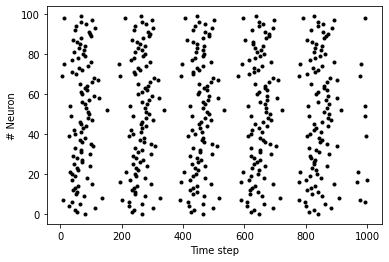

In [34]:
# convert to numpy array
voltages_arr = np.array(voltages_arr)
spikes_arr = np.array(spikes_arr)

x_range = (9000,10_000)
for i in range(n_neurons):
    spike_times = spikes_arr[x_range[0]:x_range[1],i].nonzero()[0]
    plt.scatter(spike_times + x_range[0], i*np.ones_like(spike_times), marker='.', c='black')
plt.xlabel('Time step')
plt.ylabel('# Neuron')
plt.show()

# Timeit and memory allocation

The code we wrote works, but there several things that we can do to make it run faster. Let's also time it using the Jupyter cell magic `%%timeit`:

In [109]:
params["n_neurons"] = 1_000
params["n_steps"] = 10_000

mean_I, std_I = 300, 300

In [110]:
# population1 = [ExpLIF_neuron(params) for _ in range(n_neurons)]

# # these will now become lists of lists (neurons, time steps)
# voltages_arr = []
# spikes_arr = []

In [111]:
# %%timeit -n 1 -r 3

# for i, neuron in enumerate(population1):
#     voltages = []
#     spikes = []
# #     if i % 10 == 0:
# #         print(f"Working on neuron {i}")
#     for _ in range(params["n_steps"]):
#         I = np.random.normal(mean_I, std_I)
#         v, s = neuron.LIF_step(I=I)
#         voltages.append(v)
#         spikes.append(s)
#     voltages_arr.append(voltages.copy())
#     spikes_arr.append(spikes.copy())

In [112]:
population2 = ExpLIF_population(params)

# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

In [113]:
%%timeit -n 1 -r 10

for _ in range(params["n_steps"]):
    I = np.random.normal(mean_I, std_I, size=params["n_neurons"])
    v, s = population2.LIF_step(I=I)
    voltages_arr.append(v.copy())
    spikes_arr.append(s.copy())

1.53 s ± 62.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [114]:
population3 = ExpLIF_population(params)

# these will now become lists of lists (neurons, time steps)
voltages_arr = np.zeros((params["n_steps"], params["n_neurons"]))
spikes_arr = np.zeros((params["n_steps"], params["n_neurons"]))

In [115]:
%%timeit -n 1 -r 10

for i in range(params["n_steps"]):
    I = np.random.normal(mean_I, std_I, size=params["n_neurons"])
    voltages_arr[i], spikes_arr[i] = population3.LIF_step(I=I)

1.57 s ± 83.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Let's look at some spike rasters and a histogram:

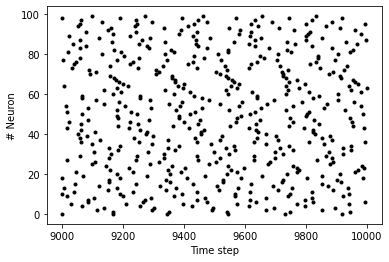

In [116]:
x_range = (9000,10_000)
for i in range(n_neurons):
    spike_times = spikes_arr[x_range[0]:x_range[1],i].nonzero()[0]
    plt.scatter(spike_times + x_range[0], i*np.ones_like(spike_times), marker='.', c='black')
plt.xlabel('Time step')
plt.ylabel('# Neuron')
plt.show()

# Broadcasting